# Project Goal:

---


This toy project compares a vanilla LSTM and a physics-aware LSTM for time series forecasting of daily maximum temperatures in Sydney. The goal is to demonstrate how even a simple physics-inspired constraint — in this case, a smoothness regularization loss — can help impose structure on data and yield more physically plausible predictions.




In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Dataset: Daily Max Temperatures, Sydney, Australia (1950–1990)

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv'

In [4]:
df = pd.read_csv(url, parse_dates=['Date'])
data = df['Temperature'].values.reshape(-1, 1)

In [5]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [6]:
def create_sequences(data, seq_len=7):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [7]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        return self.fc(out)


In [8]:
def train(model, X, y, smooth=False, lam=0.01, epochs=50):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X)

        loss = loss_fn(preds, y)

        if smooth:
            smooth_loss = torch.mean((preds[1:] - preds[:-1])**2)
            loss += lam * smooth_loss

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses, preds.detach().numpy()

In [9]:
# 6. Train vanilla LSTM
model1 = LSTMForecast()
losses1, preds1 = train(model1, X, y, smooth=False)

# 7. Train physics-aware LSTM with smoothness penalty
model2 = LSTMForecast()
losses2, preds2 = train(model2, X, y, smooth=True)

# 8. Inverse transform predictions
y_true = scaler.inverse_transform(y.numpy())
preds1_inv = scaler.inverse_transform(preds1)
preds2_inv = scaler.inverse_transform(preds2)

# Methods

*   Data normalization and sequence generation
*   LSTM baseline trained on 7-day input windows
*   Physics-aware version trained with a smoothness penalty:


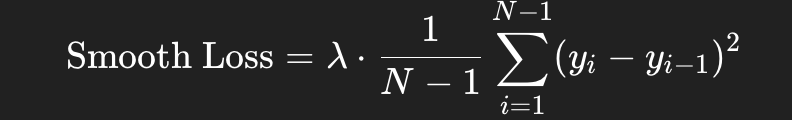








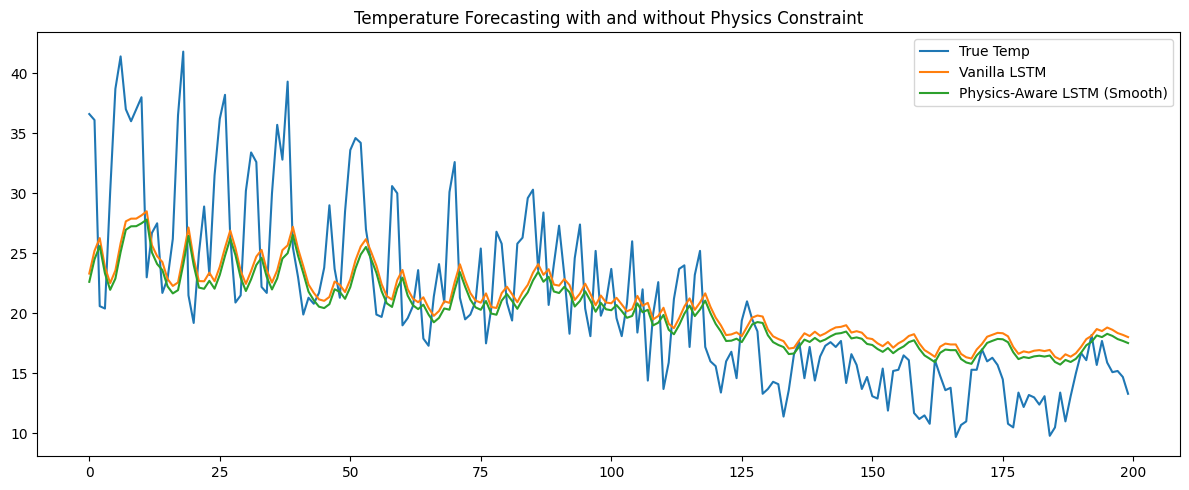

In [10]:
# 9. Plot results
plt.figure(figsize=(12, 5))
plt.plot(y_true[:200], label='True Temp')
plt.plot(preds1_inv[:200], label='Vanilla LSTM')
plt.plot(preds2_inv[:200], label='Physics-Aware LSTM (Smooth)')
plt.title("Temperature Forecasting with and without Physics Constraint")
plt.legend()
plt.tight_layout()
plt.show()

#Results
Vanilla LSTM shows good fit but tends to track noise
Physics-Aware LSTM produces smoother, more stable forecasts
The results show that simple constraints can make ML models more interpretable and robust — a foundational idea for physics-aware foundation models in climate research